#Proyecto 2: Análisis y Selección de Problema

**Parte 1: Preprocesamiento de Datos**

In [ ]:
# Importacion de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Carga de datos
df = pd.read_csv("/content/insurance.csv")

#1- Limpieza de Datos:

In [ ]:
# Ver cuántos valores nulos hay en cada columna
print("Valores nulos por cada columna")
print(df.isnull().sum())

# Ver filas con valores nulos
print("Filas con valores nulos")
print(df[df.isnull().any(axis=1)])

Valores nulos por cada columna
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Filas con valores nulos
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


In [ ]:
# Selecciona solo columnas numericas
numeric_df = df.select_dtypes(include=np.number)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
# Definir límites de detección
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
# Ver cantidad de outliers por variable
outliers = ((numeric_df < limite_inferior) | (numeric_df > limite_superior)).sum()
print("Cantidad de outliers por variable:")
print(outliers)

Cantidad de outliers por variable:
age           0
bmi           9
children      0
charges     139
dtype: int64


In [ ]:
#Crear una copia del df original
df_transformed = df.copy()
#Aplica una transformación logarítmica a la columna
df_transformed['bmi'] = np.log1p(df_transformed['bmi'])  # Transformación logarítmica
df_transformed['charges'] = np.log1p(df_transformed['charges']) # Transformación logarítmica

print("DataFrame después de aplicar transformación logarítmica:")
print(df_transformed)


DataFrame después de aplicar transformación logarítmica:
      age     sex       bmi  children smoker     region    charges
0      19  female  3.363842         0    yes  southwest   9.734236
1      18    male  3.548755         1     no  southeast   7.453882
2      28    male  3.526361         3     no  southeast   8.400763
3      33    male  3.165686         0     no  northwest   9.998137
4      32    male  3.397189         0     no  northwest   8.260455
...   ...     ...       ...       ...    ...        ...        ...
1333   50    male  3.464798         3     no  northwest   9.268755
1334   18  female  3.494080         0     no  northeast   7.699381
1335   18  female  3.633631         0     no  southeast   7.396847
1336   21  female  3.288402         0     no  southwest   7.605365
1337   61  female  3.403528         0    yes  northwest  10.279948

[1338 rows x 7 columns]


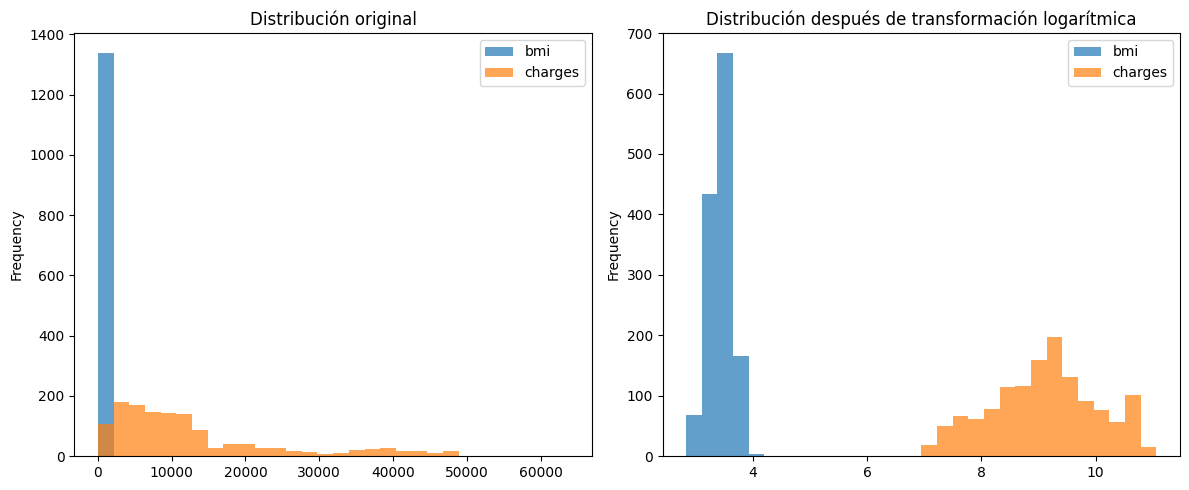

In [ ]:
# Importacion de biblioteca
import matplotlib.pyplot as plt
# Crear figura y subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Graficar distribución antes de la transformación
df[['bmi', 'charges']].plot.hist(ax=axes[0], bins=30, alpha=0.7)
axes[0].set_title("Distribución original")
# Graficar distribución después de la transformación
df_transformed[['bmi', 'charges']].plot.hist(ax=axes[1], bins=30, alpha=0.7)
axes[1].set_title("Distribución después de transformación logarítmica")
plt.tight_layout()
plt.show()

2- Transformación de Columnas:

3- Creación de Pipelines:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Definir columnas categóricas y numéricas
columnas_categoricas = ['sex', 'smoker', 'region']
columnas_numericas = ['age', 'bmi', 'children', 'charges']

# Definir el preprocesador con ColumnTransformer
preprocesador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), columnas_categoricas),
        ('num', StandardScaler(), columnas_numericas)
    ])

# Crear el pipeline con los pasos de preprocesamiento
pipeline = Pipeline([
    ('preprocesamiento', preprocesador)
])

# Aplicar el pipeline a tu conjunto de datos
data_modificado = pipeline.fit_transform(df_transformed)

# Obtener nombres de columnas transformadas
columnas_transformadas = (
    preprocesador.named_transformers_['cat']
    .get_feature_names_out(columnas_categoricas)
    .tolist() + columnas_numericas
)

# Convertir a DataFrame
df_transformado = pd.DataFrame(data_modificado, columns=columnas_transformadas)

print(df_transformado)

      sex_female  sex_male  smoker_no  smoker_yes  region_northeast  \
0            1.0       0.0        0.0         1.0               0.0   
1            0.0       1.0        1.0         0.0               0.0   
2            0.0       1.0        1.0         0.0               0.0   
3            0.0       1.0        1.0         0.0               0.0   
4            0.0       1.0        1.0         0.0               0.0   
...          ...       ...        ...         ...               ...   
1333         0.0       1.0        1.0         0.0               0.0   
1334         1.0       0.0        1.0         0.0               1.0   
1335         1.0       0.0        1.0         0.0               0.0   
1336         1.0       0.0        1.0         0.0               0.0   
1337         1.0       0.0        0.0         1.0               0.0   

      region_northwest  region_southeast  region_southwest       age  \
0                  0.0               0.0               1.0 -1.438764   
1  

#Parte 2: Selección de Técnica de Machine Learning
**Entrenamiento Inicial**:

In [ ]:
# Preparación de los Datos
from sklearn.model_selection import train_test_split

X = df_transformado.drop(columns=['charges'])
y = df_transformado['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definir los Modelos
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

modelos = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

In [ ]:
# Validación Cruzada
from sklearn.model_selection import cross_val_score
import numpy as np

resultados = {}

for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='r2')
    resultados[nombre] = np.mean(scores)

# Ordenar resultados
resultados_ordenados = dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

print("Resultados de validación cruzada:")
for modelo, score in resultados_ordenados.items():
    print(f"{modelo}: {score:.4f}")

Resultados de validación cruzada:
Random Forest: 0.8026
XGBoost: 0.7599


In [ ]:
# Selección del Mejor Modelo
from sklearn.metrics import mean_squared_error, r2_score

mejor_modelo = max(resultados, key=resultados.get)
modelo_final = modelos[mejor_modelo]
modelo_final.fit(X_train, y_train)

y_pred = modelo_final.predict(X_test)

print(f"Evaluación del modelo {mejor_modelo}:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")

Evaluación del modelo Random Forest:
MSE: 0.1638
R2: 0.8461


**Comparación de Modelos**:

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


modelos = {
    "Random Forest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

y_pred_rf = modelos["Random Forest"].fit(X_train, y_train).predict(X_test)
y_pred_xgb = modelos["XGBoost"].fit(X_train, y_train).predict(X_test)

# clasificar los valores
umbral = np.median(y_test)
y_test_binario = (y_test >= umbral).astype(int)

# Predicciones binarias basadas en la mediana del conjunto de entrenamiento
y_pred_rf_binario = (y_pred_rf >= umbral).astype(int)
y_pred_xgb_binario = (y_pred_xgb >= umbral).astype(int)

# Calcular métricas
roc_auc_rf = roc_auc_score(y_test_binario, y_pred_rf_binario)
f1_rf = f1_score(y_test_binario, y_pred_rf_binario)

roc_auc_xgb = roc_auc_score(y_test_binario, y_pred_xgb_binario)
f1_xgb = f1_score(y_test_binario, y_pred_xgb_binario)

# Mostrar resultados
print("Comparación de métricas:")
print(f"Random Forest - ROC-AUC: {roc_auc_rf:.4f}, F1-Score: {f1_rf:.4f}")
print(f"XGBoost - ROC-AUC: {roc_auc_xgb:.4f}, F1-Score: {f1_xgb:.4f}")

Comparación de métricas:
Random Forest - ROC-AUC: 0.9142, F1-Score: 0.9158
XGBoost - ROC-AUC: 0.9142, F1-Score: 0.9151


#Parte 3: Optimización de Hiperparámetros
**GridSearchCV**:

In [ ]:
# Predicciones binarias basadas en la mediana del conjunto de entrenamiento
umbral = np.median(y_train) # Usar la mediana del conjunto de entrenamiento para binarizar y_train
y_train_binario = (y_train >= umbral).astype(int)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier  # Ahora usamos la versión de clasificación
import numpy as np # Importar numpy para usar np.median y astype

# Definir el modelo base
modelo_rf = RandomForestClassifier()

# Espacio de búsqueda de hiperparámetros
parametros_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definir el umbral basado en la mediana del conjunto de entrenamiento
# Esto es necesario porque GridSearchCV para un clasificador necesita etiquetas binarias
umbral = np.median(y_train) # Usar la mediana del conjunto de entrenamiento
y_train_binario = (y_train >= umbral).astype(int) # Crear la variable y_train_binario

# Configurar GridSearchCV
grid_search = GridSearchCV(
    modelo_rf, parametros_rf,
    cv=5, scoring='f1',
    n_jobs=-1, verbose=2
)

# Ejecutar búsqueda de hiperparámetros
# Ahora usamos la versión binaria de la variable objetivo para el clasificador
grid_search.fit(X_train, y_train_binario)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntaje F1-Score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntaje F1-Score: 0.9253716170041801


**RandomizedSearchCV**:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Definir el modelo base
modelo_rf = RandomForestClassifier()

# Espacio de búsqueda con rango más amplio
parametros_rf = {
    'n_estimators': np.arange(50, 300, 50),  # Número de árboles (50 a 300 en pasos de 50)
    'max_depth': [None, 10, 20, 30, 40],  # Profundidad máxima de los árboles
    'min_samples_split': np.arange(2, 11, 2),  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': np.arange(1, 5),  # Mínimo número de muestras en una hoja
    'bootstrap': [True, False]  # Uso de muestreo con reemplazo
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    modelo_rf, parametros_rf,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    cv=5, scoring='f1',
    n_jobs=-1, verbose=2, random_state=42
)

# Ejecutar búsqueda de hiperparámetros
random_search.fit(X_train, y_train_binario)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntaje F1-Score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros: {'n_estimators': np.int64(200), 'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(3), 'max_depth': 40, 'bootstrap': False}
Mejor puntaje F1-Score: 0.9242949410551947


**Evaluación del modelo**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Modelo optimizado con los mejores hiperparámetros
modelo_rf_optimo = RandomForestClassifier(**random_search.best_params_)
modelo_rf_optimo.fit(X_train, y_train_binario)

# Predicciones
y_pred_optimo = modelo_rf_optimo.predict(X_test)

# Evaluación final
print("Evaluación del modelo optimizado:")
print(f"Exactitud: {accuracy_score(y_test_binario, y_pred_optimo):.4f}")
print(f"F1-Score: {f1_score(y_test_binario, y_pred_optimo):.4f}")

Evaluación del modelo optimizado:
Exactitud: 0.9142
F1-Score: 0.9069


**Optuna**:

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 40)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Definir el modelo con los hiperparámetros elegidos
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap, random_state=42
    )

    # Evaluar con validación cruzada
    score = cross_val_score(model, X_train, y_train_binario, cv=5, scoring='f1').mean()

    return score  # Maximizar F1-Score

# Crear estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)
print("Mejor puntaje F1-Score:", study.best_value)


[I 2025-05-17 01:07:08,012] A new study created in memory with name: no-name-e2495f6f-ff28-4634-bf65-5b7a8ca118c1
[I 2025-05-17 01:07:13,962] Trial 0 finished with value: 0.9231264874212156 and parameters: {'n_estimators': 282, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.9231264874212156.
[I 2025-05-17 01:07:14,700] Trial 1 finished with value: 0.9200712284121966 and parameters: {'n_estimators': 67, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.9231264874212156.
[I 2025-05-17 01:07:15,184] Trial 2 finished with value: 0.9199273944994693 and parameters: {'n_estimators': 51, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.9231264874212156.
[I 2025-05-17 01:07:16,854] Trial 3 finished with value: 0.9221776878607815 and parameters: {'n_estimators': 186, 'max_depth': 34, 'min_samples_split'

Mejores hiperparámetros: {'n_estimators': 189, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}
Mejor puntaje F1-Score: 0.9252103639407668


**Evaluación del modelo**

In [ ]:
# Modelo optimizado con los mejores hiperparámetros
modelo_rf_optimo = RandomForestClassifier(**study.best_params)
modelo_rf_optimo.fit(X_train, y_train_binario)

# Predicciones y evaluación final
y_pred_optimo = modelo_rf_optimo.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print("Evaluación del modelo optimizado:")
print(f"Exactitud: {accuracy_score(y_test_binario, y_pred_optimo):.4f}")
print(f"F1-Score: {f1_score(y_test_binario, y_pred_optimo):.4f}")

Evaluación del modelo optimizado:
Exactitud: 0.9142
F1-Score: 0.9069


**Evaluación de Modelos Optimizados**:

In [ ]:
# Modelo optimizado con los mejores hiperparámetros de Optuna
modelo_rf_optimo = RandomForestClassifier(**study.best_params)
modelo_rf_optimo.fit(X_train, y_train_binario)

# Predicciones en el conjunto de prueba
y_pred_optimo = modelo_rf_optimo.predict(X_test)

**Calculamos Exactitud y F1-Score**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluación
exactitud_optima = accuracy_score(y_test_binario, y_pred_optimo)
f1_optima = f1_score(y_test_binario, y_pred_optimo)

print(f"Modelo Optimizado - Exactitud: {exactitud_optima:.4f}, F1-Score: {f1_optima:.4f}")

Modelo Optimizado - Exactitud: 0.9142, F1-Score: 0.9069


**Comparación con el Modelo Inicial**

In [ ]:
# Evaluación del modelo inicial antes de la optimización
y_pred_inicial = modelos["Random Forest"].predict(X_test)

# Convertir las predicciones a binarias
umbral = np.median(y_test) # Usar la mediana del conjunto de prueba
y_pred_inicial_binario = (y_pred_inicial >= umbral).astype(int)

# predicciones binarias para calcular las métricas de clasificación
exactitud_inicial = accuracy_score(y_test_binario, y_pred_inicial_binario)
f1_inicial = f1_score(y_test_binario, y_pred_inicial_binario)

print("Comparación de Rendimiento:")
print(f"Modelo Inicial - Exactitud: {exactitud_inicial:.4f}, F1-Score: {f1_inicial:.4f}")
print(f"Modelo Optimo - Exactitud: {exactitud_optima:.4f}, F1-Score: {f1_optima:.4f}")

Comparación de Rendimiento:
Modelo Inicial - Exactitud: 0.9142, F1-Score: 0.9158
Modelo Optimo - Exactitud: 0.9142, F1-Score: 0.9069
